# Importando bibliotecas necessárias

In [3]:
import os
import itertools
from glob import glob

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf 
from tensorflow.keras import regularizers # Ajuda a evitar overfitting aplicando penalidades para que os pesos sejam menores
from tensorflow.keras.models import Sequential # Cria rede neural emplihando camadas sequenciais
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization # Tipos de camadas de redes neurais
from tensorflow.keras.optimizers import Adamax # Ajuda a optimizar o modelo (Controla os passos de cada treino)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Tratamento de imagens

# Carregando arquivos em um dataframe

In [4]:
def load_files(dir):
    return glob(f'{dir}/*')

def load_data(path):
    dirs = os.listdir(path)

    dfs = []

    for dir in dirs:
      path_dir = os.path.join(path, dir)
      dfs.append(pd.DataFrame(load_files(path_dir), columns=['image_path']))

    df = pd.concat(dfs)
    df['label'] = df['image_path'].apply(lambda x: x.split('\\')[-2].lower())
    return df

root_path = './images\\'

df = load_data(root_path)

# Análise de dados

## Classes padrão bem balanceadas

o dataset possui 1000 imagens
--------------------------------------------------------
o dataset possui 4 classes
--------------------------------------------------------


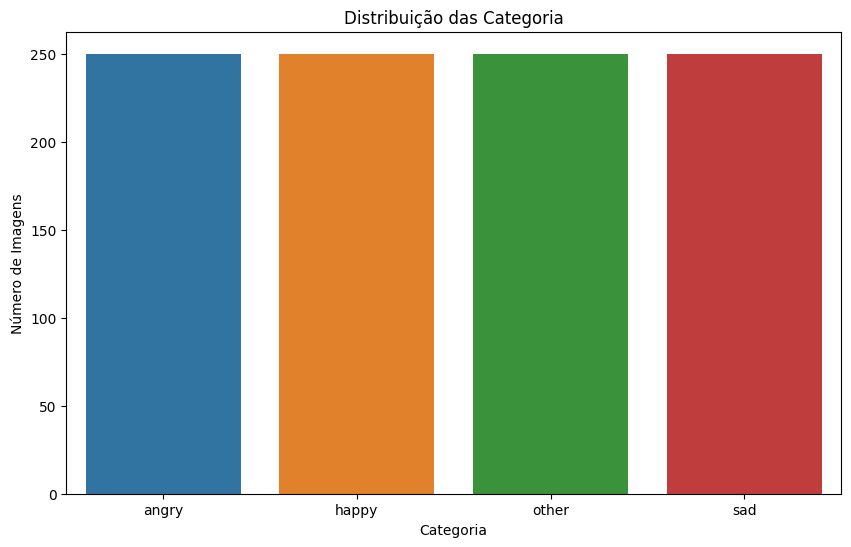

In [5]:
def plot_graph(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', hue='label', legend=False)
    plt.title('Distribuição das Categoria')
    plt.xlabel('Categoria')
    plt.ylabel('Número de Imagens')
    plt.show()

def analyse_df(df, name = 'dataset'):
    print(f'o {name} possui {df.shape[0]} imagens')
    print('--------------------------------------------------------')
    print(f'o {name} possui {df.label.nunique()} classes')
    print('--------------------------------------------------------')

analyse_df(df)
plot_graph(df)

## Dividindo em treino, teste e validação e conferindo o balanceamento

In [6]:
# pegando porção de treinamento, o argumento stratify é usado para separar mantendo o balanceamento das classes
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state=42, stratify=df['label'])

# pegando porção de validação e testes
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state=42, stratify=dummy_df['label'])

o df_train possui 800 imagens
--------------------------------------------------------
o df_train possui 4 classes
--------------------------------------------------------


o df_valid possui 120 imagens
--------------------------------------------------------
o df_valid possui 4 classes
--------------------------------------------------------


o df_test possui 80 imagens
--------------------------------------------------------
o df_test possui 4 classes
--------------------------------------------------------




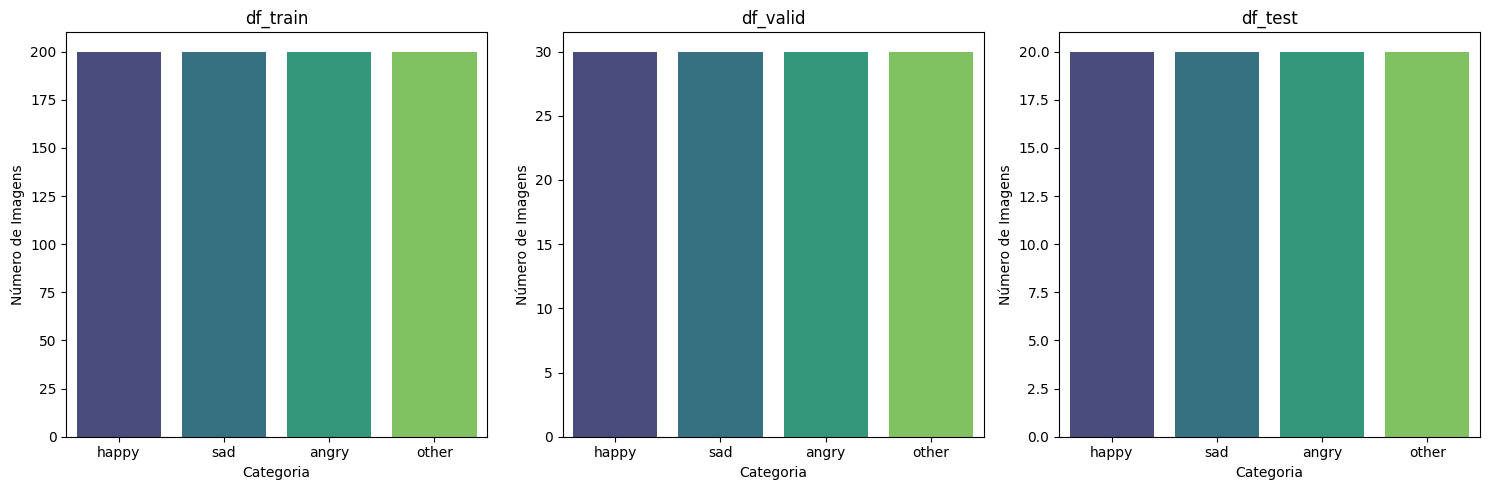

In [7]:
def plot_split_datasets(dfs):
    labels = ['happy', 'sad', 'angry', 'other']

    # Cria uma paleta de cores específica para cada label
    palette = sns.color_palette("viridis", len(labels))
    color_dict = dict(zip(labels, palette))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, (name, df) in enumerate(dfs.items()):
        sns.countplot(data=df, x='label', order=labels, palette=color_dict, ax=axs[i], hue='label')
        axs[i].set_title(name)
        axs[i].set_xlabel('Categoria')
        axs[i].set_ylabel('Número de Imagens')
        axs[i].legend([], [], frameon=False)  # Remove a legenda

    plt.tight_layout()
    plt.show()


def analyses_datasets(dfs):
    for name, df in dfs.items():
      analyse_df(df, name)
      print('\n')

    plot_split_datasets(dfs)

dfs = {'df_train': train_df, 'df_valid':valid_df, 'df_test': test_df}

analyses_datasets(dfs)

# Construção e treinamento do modelo

## Configurações usadas no futuro

In [8]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

## Tratamento e padronização das imagens

In [9]:
def scalar(img):
    return img

gen = ImageDataGenerator(preprocessing_function= scalar, brightness_range=[0.4,0.6])

train_gen = gen.flow_from_dataframe(train_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= 'rgb', 
                                    shuffle= True, 
                                    batch_size= batch_size
                                )

valid_gen = gen.flow_from_dataframe(valid_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= 'rgb', 
                                    shuffle= True, 
                                    batch_size= batch_size
                                )

test_gen = gen.flow_from_dataframe(test_df, 
                                    x_col= 'image_path', 
                                    y_col= 'label', 
                                    target_size= img_size, 
                                    class_mode= 'categorical',
                                    color_mode= 'rgb', 
                                    shuffle= False, 
                                    batch_size= test_batch_size
                                )

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


## Criação do modelo

In [12]:
def create_model():
    class_count = len(list(train_gen.class_indices.keys()))

    # Carregando o modelo EfficientNet com o padrão de imagens esperado. Include_top = false, pois não queremos a última camada já que vamos adicionar mais camadas
    base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
    # "Travando" a base_model para não influenciar o que já esta treinado
    base_model.trainable = False

    # Criando a rede neural
    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001), # Camada de normalização, usada para acelerar o treinamento e estabilizar
        Dense(256, activation='relu'), # Camada densa onde todos os 256 neurônios estão ligados
        Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                    bias_regularizer= regularizers.l1(0.006), activation= 'relu'), # Mais uma camada densa, com menos neurônios e com tratamento nos pesos para evitar overfitting
        Dropout(rate= 0.45, seed= 123), # Usado para evitar overfitting, 45% dos neurônios serão desativados temporariamente
        Dense(class_count, activation= 'softmax') # Camada densa final, recebe o número de classes para separar as entradas entre elas com base em probabilidade
    ])

    # Compilando o modelo com passos pequenos em busca de melhor performance
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
    return model

model = create_model()
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                      

## Treinando o modelo

In [30]:
epochs = 25

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle=False
                )

Epoch 1/25
50/50 [==============================] - 209s 4s/step - loss: 4.4158 - accuracy: 0.4375 - val_loss: 4.0227 - val_accuracy: 0.5917
Epoch 2/25
50/50 [==============================] - 150s 3s/step - loss: 3.6090 - accuracy: 0.5975 - val_loss: 3.3626 - val_accuracy: 0.7000
Epoch 3/25
50/50 [==============================] - 135s 3s/step - loss: 3.2791 - accuracy: 0.6787 - val_loss: 3.0842 - val_accuracy: 0.7917
Epoch 4/25
50/50 [==============================] - 141s 3s/step - loss: 3.0231 - accuracy: 0.7688 - val_loss: 2.9179 - val_accuracy: 0.8167
Epoch 5/25
50/50 [==============================] - 152s 3s/step - loss: 2.8768 - accuracy: 0.7663 - val_loss: 2.7189 - val_accuracy: 0.8750
Epoch 6/25
50/50 [==============================] - 185s 4s/step - loss: 2.7074 - accuracy: 0.8250 - val_loss: 2.6196 - val_accuracy: 0.8750
Epoch 7/25
50/50 [==============================] - 180s 4s/step - loss: 2.5610 - accuracy: 0.8375 - val_loss: 2.4810 - val_accuracy: 0.8500
Epoch 8/25
50

## Validação do modelo

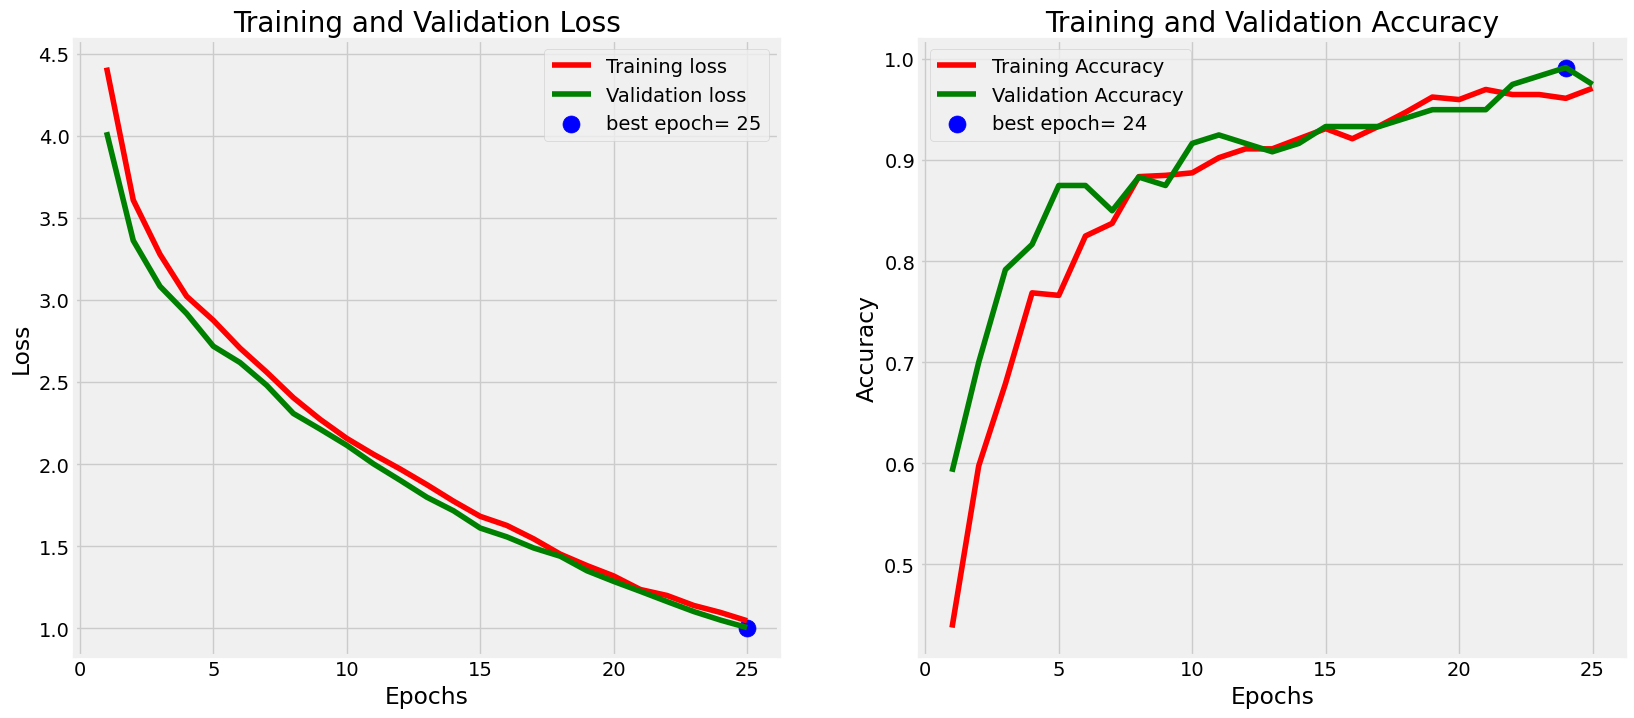

In [32]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [33]:
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 11s 11s/step - loss: 0.9786 - accuracy: 0.9750
Train Loss:  0.9004884958267212
Train Accuracy:  1.0
--------------------
Test Loss:  0.9786491394042969
Test Accuracy:  0.9750000238418579


### Prevendo com base no df de testes e validação dos resultados

In [34]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

C:\Users\gusta\AppData\Local\Temp\ipykernel_4364\2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


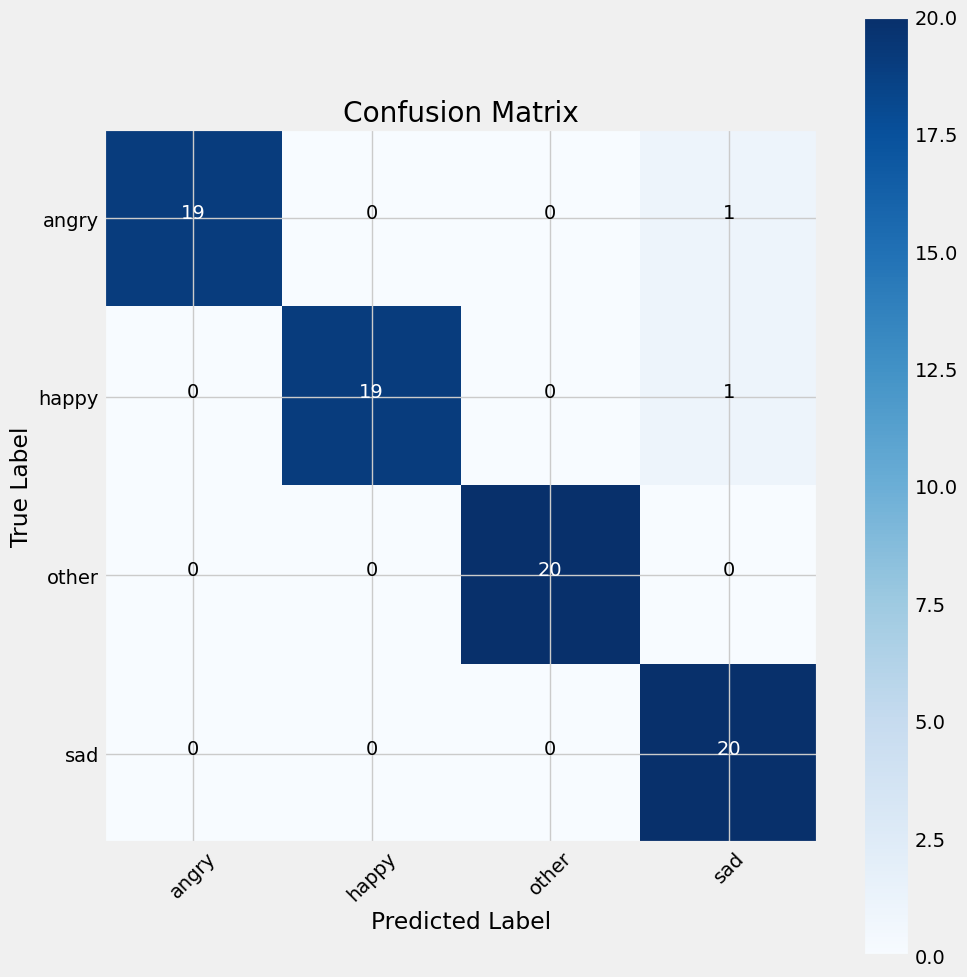

In [37]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [38]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       1.00      0.95      0.97        20
       happy       1.00      0.95      0.97        20
       other       1.00      1.00      1.00        20
         sad       0.91      1.00      0.95        20

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.98        80
weighted avg       0.98      0.97      0.98        80



## Salvando os pesos utilizados no modelo

In [31]:
model.save_weights('models/modelo_pesos.h5')

# Testes do modelo

1/1 [==============================] - 3s 3s/step


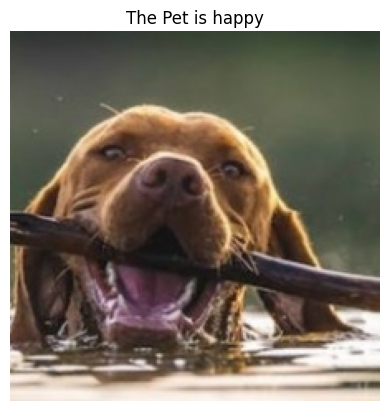

In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title(f"The pet is normal")
    else:
        plt.title(f"The Pet is {predicted_class_label}")
    plt.show()

model = create_model()

model.load_weights('models/modelo_pesos.h5')

class_labels = ['Angry', 'Other', 'Sad', 'Happy']


emotion = input("Enter the emotion you want to predict: ")
file = input("Enter the file name: ")

image_path_to_test = f'images/{emotion}/{file}'
# image_path_to_test = f'my-pets/paçoca.jpg'
predict_and_display(image_path_to_test, model)